In [1985]:
import pandas as pd
import numpy as np
from keras.api.models import Sequential
from keras.api.layers import Dense, Input
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [1986]:
# Carregar os dados
data = pd.read_csv("sinais_vitais.txt", header=None)

In [1987]:
# Seleção de variáveis preditoras e alvos
X = data.iloc[:, [3, 4, 5]].values  # si3 (qualidade da pressão), si4 (pulso), si5 (respiração)
y_gravity = data.iloc[:, -2].values  # Gravidade contínua
y_labels = data.iloc[:, -1].values  # Rótulo de saída

In [1988]:
# Normalização
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [1989]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X_normalized, y_gravity, y_labels, test_size=0.2, random_state=42
)

In [1990]:
# Modelo de Regressão para prever gravidade contínua
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)  # Saída contínua
])

In [ ]:
optimizer = Adam(learning_rate=0.001)

model.compile(loss='mse', metrics=['mae'], optimizer=optimizer)

In [1992]:
# Treinamento
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1778.4960 - mae: 33.3735 - val_loss: 205.8823 - val_mae: 11.5199
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163.8981 - mae: 10.1152 - val_loss: 81.0457 - val_mae: 7.1208
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.9689 - mae: 6.7197 - val_loss: 37.0157 - val_mae: 4.5612
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.7318 - mae: 5.7622 - val_loss: 38.0145 - val_mae: 4.5762
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.6900 - mae: 5.0875 - val_loss: 27.0117 - val_mae: 3.8797
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.1045 - mae: 3.9068 - val_loss: 26.2500 - val_mae: 3.6946
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.4879 - mae: 4.2771 - val_loss: 46.7841 - val_mae: 5.7140
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.5341 - mae: 4.5090 - val_loss: 30.7162 - val_mae: 4.2665
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s

In [1993]:
# Previsões
y_pred = model.predict(X_test).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [1994]:
# Classificação com base nos intervalos fixos
def classify_gravity(value):
    if 0 <= value <= 25:
        return 1
    elif 25 < value <= 50:
        return 2
    elif 50 < value <= 75:
        return 3
    elif 75 < value <= 100:
        return 4

In [1995]:
# Prever gravidade contínua no conjunto de teste
y_pred_continuous = model.predict(X_test).flatten()

# Mapear previsões contínuas para classes
y_pred_classes = np.array([classify_gravity(v) for v in y_pred_continuous])

# Mapear os valores reais de gravidade para classes
y_test_classes = np.array([classify_gravity(v) for v in y_test])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [1996]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Acurácia da classificação
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Acurácia da classificação: {accuracy:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test_classes, y_pred_classes))

# Número de acertos (diagonal da matriz de confusão)
correct_predictions = np.trace(conf_matrix)

# Número total de amostras
total_predictions = np.sum(conf_matrix)

# Porcentagem de acertos
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Porcentagem de Acertos: {accuracy_percentage:.2f}%")

Acurácia da classificação: 0.8733
Matriz de Confusão:
 [[ 44   2   0   0]
 [ 14 147  10   0]
 [  0   2  65  10]
 [  0   0   0   6]]
Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.76      0.96      0.85        46
           2       0.97      0.86      0.91       171
           3       0.87      0.84      0.86        77
           4       0.38      1.00      0.55         6

    accuracy                           0.87       300
   macro avg       0.74      0.92      0.79       300
weighted avg       0.90      0.87      0.88       300

Porcentagem de Acertos: 87.33%


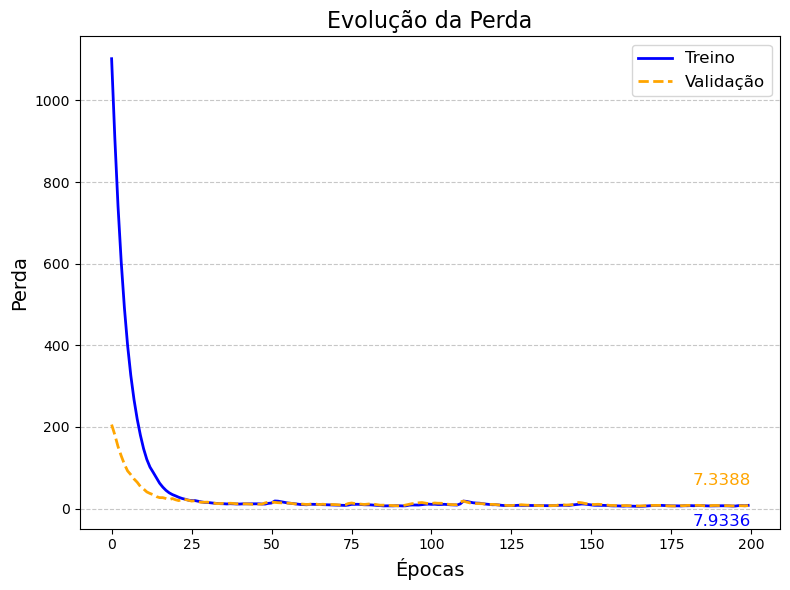

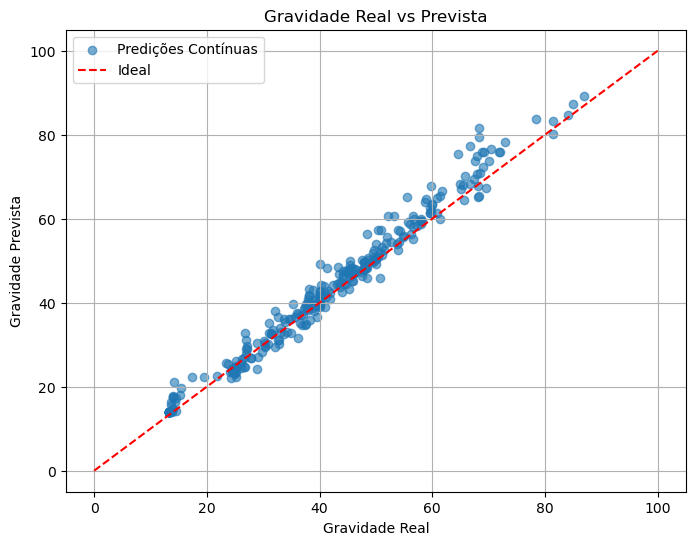

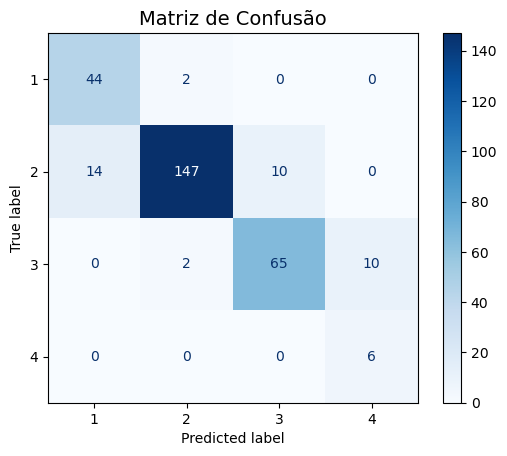

In [1997]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Função para suavizar curvas com médias móveis
def smooth_curve(values, weight=0.80):
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# Gráfico de Perda
plt.figure(figsize=(8, 6))
train_loss = smooth_curve(history.history["loss"])
val_loss = smooth_curve(history.history["val_loss"])
plt.plot(train_loss, label="Treino", linewidth=2, color="blue")
plt.plot(val_loss, label="Validação", linewidth=2, linestyle="--", color="orange")
plt.title("Evolução da Perda", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Perda", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adicionar anotação dos valores finais
plt.annotate(
    f"{train_loss[-1]:.4f}",
    xy=(len(train_loss) - 1, train_loss[-1]),
    xytext=(-40, -15),
    textcoords="offset points",
    fontsize=12,
    color="blue",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(len(val_loss) - 1, val_loss[-1]),
    xytext=(-40, 15),
    textcoords="offset points",
    fontsize=12,
    color="orange",
)

plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_continuous, alpha=0.6, label="Predições Contínuas")
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label="Ideal")
plt.xlabel("Gravidade Real")
plt.ylabel("Gravidade Prevista")
plt.title("Gravidade Real vs Prevista")
plt.legend()
plt.grid()
plt.show()

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Exibir a matriz de confusão com o display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4])

# Plotar a matriz de confusão
disp.plot(cmap="Blues", values_format="d")

# Título e exibição
plt.title("Matriz de Confusão", fontsize=14)
plt.show()
